# [Multi-class classification with focal loss for imbalanced datasets](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)
## Baseline model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

In [2]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [3]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [4]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [5]:
#Splitting the Training/Test Data

from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

D:\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [6]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential()

from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [9]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0 : 1., 1: 20.}
model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)

Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 0.0521 - acc: 0.9973
Epoch 2/3
5090096/5090096 [==============================] - 23s 5us/step - loss: 0.0331 - acc: 0.9982
Epoch 3/3
5090096/5090096 [==============================] - 23s 5us/step - loss: 0.0307 - acc: 0.9982


In [10]:
score = model.evaluate(X_test, y_test, batch_size=1000)
score

1272524/1272524 [==============================] - 2s 2us/step


[0.008506381044709285, 0.9987269476573256]

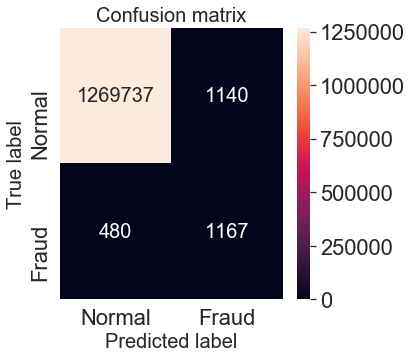

In [16]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

### Total miss-classified labels

In [17]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count

1620